### Normalização das imagens filtered entre 0 e 255

In [79]:
import SimpleITK as sitk
import numpy as np

def normalize_img(image):
    imagem = sitk.ReadImage("images_filtered/IXI002-Guys-0828-T1.nii.gz")
    img_np = sitk.GetArrayFromImage(imagem)

    data_min = np.min(img_np)
    data_max = np.max(img_np)
    normalized_data = (img_np - data_min) / (data_max - data_min) * 255
    normalized_data = normalized_data.astype(np.uint8)
    image_norm = sitk.GetImageFromArray(normalized_data)
    return image_norm
    

### Função

In [73]:
import os
def read_directories(directory, img=None):
    # Get a list of filenames in the specified directory
    filenames = []
    for filename in os.listdir(directory):
        if img is not None:
            # If 'img' is provided, filter filenames containing it
            if img in filename:   
                filenames.append(filename)          
        else:
            filenames.append(filename)    
    return filenames

### Normalizando as imagens filtradas

In [82]:
dir_images = f'images_filtered'
array_images = read_directories(dir_images)
dir_out = f'normalizeds'


for image in array_images:
    path = f'{dir_images}/{image}'
    name_out = f'{dir_out}/{image}'
    image_normalized = normalize_img(path)
    sitk.WriteImage(image_normalized, name_out)
    
    

In [100]:
array_normalizeds = read_directories(dir_out)

### Extraindo as médias dos valores de CSF, GM e WM

In [97]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
def calc_means_csf_gm_wm(path):
    #imagem que vai ser usada como teste
    imagem = sitk.ReadImage(f"normalizeds/{path}")
    img_np = sitk.GetArrayFromImage(imagem)


    atlas_csf = sitk.ReadImage(f"atlas_resampled/{path}/mni_csf.nii.gz")
    atlas_gm = sitk.ReadImage(f"atlas_resampled/{path}/mni_gm.nii.gz")
    atlas_wm = sitk.ReadImage(f"atlas_resampled/{path}/mni_wm.nii.gz")

    atlas_csf_array = sitk.GetArrayFromImage(atlas_csf)
    atlas_gm_array = sitk.GetArrayFromImage(atlas_gm)
    atlas_wm_array = sitk.GetArrayFromImage(atlas_wm)

    binary_array_csf = (atlas_csf_array > 0.98).astype(np.uint8)
    binary_array_gm = (atlas_gm_array > 0.98).astype(np.uint8)
    binary_array_wm = (atlas_wm_array > 0.98).astype(np.uint8)

    # Converter de volta para imagem SimpleITK
    binary_image_csf = sitk.GetImageFromArray(binary_array_csf)
    binary_image_csf.CopyInformation(atlas_csf)  # Mantém metadados da imagem original

    binary_image_gm = sitk.GetImageFromArray(binary_array_gm)
    binary_image_gm.CopyInformation(atlas_gm)  # Mantém metadados da imagem original

    binary_image_wm = sitk.GetImageFromArray(binary_array_wm)
    binary_image_wm.CopyInformation(atlas_wm)  # Mantém metadados da imagem original

    mask_np_csf = (binary_array_csf > 0).astype(np.uint8)
    mask_np_gm = (binary_array_gm > 0).astype(np.uint8)
    mask_np_wm = (binary_array_wm > 0).astype(np.uint8)

    result_np_csf = (img_np * mask_np_csf)
    result_np_gm = (img_np * mask_np_gm)
    result_np_wm = (img_np * mask_np_wm)

    vetor_np_csf = result_np_csf[result_np_csf>0]
    vetor_np_csf_mean = np.mean(vetor_np_csf)

    vetor_np_gm = result_np_gm[result_np_gm>0]
    vetor_np_gm_mean = np.mean(vetor_np_gm)

    vetor_np_wm = result_np_wm[result_np_wm>0]
    vetor_np_wm_mean = np.mean(vetor_np_wm)


    dict = {
        'CSF':vetor_np_csf_mean,
        'GM':vetor_np_gm_mean,
        'WM':vetor_np_wm_mean
    }
    return dict


### Usar o kmeans com as três médias advindas das imagens. Fazer a clusterização da imagem original mediante as três médias.

Convergência atingida após 8 iterações.


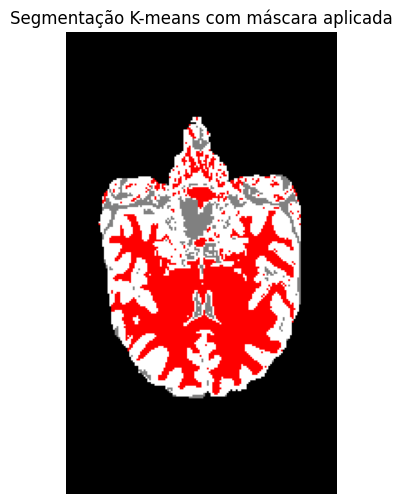


Volumes calculados:
Classe 0 (CSF): 712198.00 mm³
Classe 1 (GM): 8346355.00 mm³
Classe 2 (WM): 771847.00 mm³
Convergência atingida após 8 iterações.


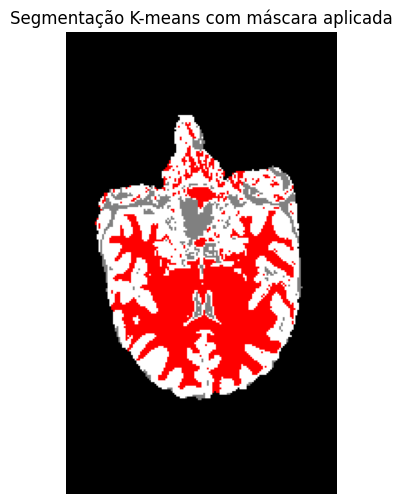


Volumes calculados:
Classe 0 (CSF): 711337.00 mm³
Classe 1 (GM): 8346179.00 mm³
Classe 2 (WM): 772884.00 mm³
Convergência atingida após 8 iterações.


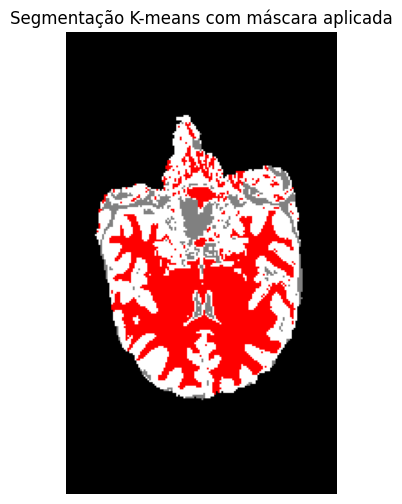


Volumes calculados:
Classe 0 (CSF): 710827.00 mm³
Classe 1 (GM): 8347490.00 mm³
Classe 2 (WM): 772083.00 mm³
Convergência atingida após 8 iterações.


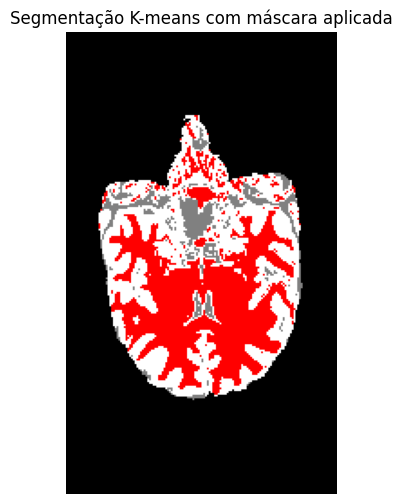


Volumes calculados:
Classe 0 (CSF): 711542.00 mm³
Classe 1 (GM): 8345515.00 mm³
Classe 2 (WM): 773343.00 mm³
Convergência atingida após 7 iterações.


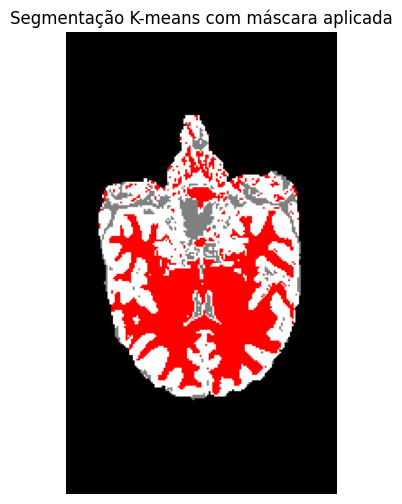


Volumes calculados:
Classe 0 (CSF): 711370.00 mm³
Classe 1 (GM): 8345445.00 mm³
Classe 2 (WM): 773585.00 mm³


In [109]:
dir_output_segmented = f'segmenteds'

for image in array_normalizeds:
    # --- Carregar a imagem original ---
    image_path = f"normalizeds\{image}"  # Modifique para o caminho da sua imagem
    nifti_image = nib.load(image_path)
    image_data = nifti_image.get_fdata()  # Array NumPy da imagem

    # --- Carregar a máscara ---
    mask_path = f"atlas_resampled\{image}\mni_mask.nii.gz"  # Caminho do arquivo enviado
    mask_nifti = nib.load(mask_path)
    mask_data = mask_nifti.get_fdata()  # Array NumPy da máscara

    # --- Aplicar a máscara (mantendo apenas a parte branca) ---
    image_data[mask_data == 0] = 0

    # Obter o tamanho do voxel em mm (dimensão do voxel)
    voxel_size = np.prod(nifti_image.header.get_zooms())  # Multiplica (dx, dy, dz) para obter mm³

    dicionario = calc_means_csf_gm_wm(image)
    vetor_np_csf_mean = dicionario['CSF']
    vetor_np_gm_mean = dicionario['GM']
    vetor_np_wm_mean = dicionario['WM']

    # Definir as médias fornecidas para os 3 clusters
    cluster_means = np.array([[vetor_np_csf_mean], [vetor_np_gm_mean], [vetor_np_wm_mean]])  # Exemplo de valores médios

    # Número de clusters
    k = len(cluster_means)

    # Inicializar centroides com as médias fornecidas
    centroids = cluster_means.copy()

    # Função para atribuir cada pixel ao cluster mais próximo
    def assign_to_cluster(image_data, centroids):
        distances = np.abs(image_data[..., None] - centroids.flatten())
        return np.argmin(distances, axis=-1)

    # Função para atualizar os centroids
    def update_centroids(image_data, labels, k):
        new_centroids = np.zeros(k)
        for i in range(k):
            if np.any(labels == i):
                new_centroids[i] = np.mean(image_data[labels == i])
            else:
                new_centroids[i] = centroids[i]  # Mantém se não houver atualização
        return new_centroids

    # Número máximo de iterações
    max_iters = 100
    tolerance = 1e-4
    prev_centroids = np.zeros_like(centroids)

    # Iteração do K-means
    for iteration in range(max_iters):
        labels = assign_to_cluster(image_data, centroids)
        centroids = update_centroids(image_data, labels, k)
        
        if np.all(np.abs(centroids - prev_centroids) < tolerance):
            print(f"Convergência atingida após {iteration + 1} iterações.")
            break
        
        prev_centroids = centroids.copy()

    # Criar uma imagem RGB para visualização
    segmented_rgb = np.zeros((*labels.shape, 3), dtype=np.uint8)

    # Definir as cores (R, G, B)
    colors = {
        0: [255, 0, 0],      # Vermelho (Primeira classe)
        1: [128, 128, 128],      # Cinza (Segunda classe)
        2: [255, 255, 255],  # Branco (Terceira classe)
    }

    # Atribuir cores aos pixels classificados
    for class_id, color in colors.items():
        segmented_rgb[labels == class_id] = color

    # Aplicar a máscara na segmentação (fundo preto)
    segmented_rgb[mask_data == 0] = [0, 0, 0]

    # Mostrar um corte da segmentação
    slice_index = segmented_rgb.shape[0] // 2  # Pegar um corte no meio
    plt.figure(figsize=(8, 6))
    plt.imshow(segmented_rgb[slice_index])  # Mostrar a imagem colorida
    plt.title("Segmentação K-means com máscara aplicada")
    plt.axis("off")
    plt.show()
    #nib.save(segmented_rgb,filename='segmented_rgb.nii.gz')

    # --- Cálculo do Volume ---
    volumes = {}
    for class_id in range(k):
        num_voxels = np.sum(labels == class_id)  # Contar número de voxels na classe
        volume_mm3 = num_voxels * voxel_size  # Multiplicar pelo tamanho do voxel
        volumes[class_id] = volume_mm3

    # Exibir resultados
    print("\nVolumes calculados:")
    for class_id, volume in volumes.items():
        print(f"Classe {class_id} ({['CSF', 'GM', 'WM'][class_id]}): {volume:.2f} mm³")

    segmented_nifti = nib.Nifti1Image(segmented_rgb, affine=nifti_image.affine, header=nifti_image.header)

    
    # --- Salvar a imagem segmentada ---
    nib.save(segmented_nifti, f'{dir_output_segmented}/{image}')

### Tentando criar uma máscara melhor

In [105]:
import nibabel as nib
import numpy as np

# Lista com os caminhos dos três atlas
atlas_paths = ["atlas\mni_csf.nii.gz",
                "atlas\mni_gm.nii.gz", 
                "atlas\mni_wm.nii.gz"]

# Carregar os atlas como arrays numpy
atlas_images = [nib.load(path) for path in atlas_paths]
atlas_data = [img.get_fdata() for img in atlas_images]

# Somar os atlas voxel a voxel
soma_atlas = np.sum(atlas_data, axis=0)

# Criar uma máscara inicial onde qualquer atlas já for 1
mascara_existente = np.any([data == 1 for data in atlas_data], axis=0)

# Criar uma nova máscara onde a soma seja exatamente 1 OU já for 1 em algum atlas
mascara_final = np.logical_or(soma_atlas >= 1, mascara_existente).astype(np.uint8)

# Criar uma nova imagem NIfTI
nova_img = nib.Nifti1Image(mascara_final, affine=atlas_images[0].affine)

# Salvar o resultado
nib.save(nova_img, "mascara_resultado.nii.gz")

print("Máscara salva como 'mascara_resultado.nii.gz'")

Máscara salva como 'mascara_resultado.nii.gz'
